In [0]:
# !git config --global user.email "me@example.com"
# !git config --global user.name "nervuzz"
# !git commit -m 'Day 4'
# !git pull
# !git add .
# !git status
# !git push

In [1]:
cd "drive/My Drive/Colab Notebooks/data_workshop_tsr/"

/content/drive/My Drive/Colab Notebooks/data_workshop_tsr


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from datetime import datetime
from skimage import color, exposure
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
%load_ext tensorboard

In [0]:
signs = pd.read_csv('data/signnames.csv')
# signs.head()
labels_dict = signs.to_dict()['b']

In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

# train.keys(), test.keys()

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [0]:
# We have to create a matrix with n columns where n is number of unique labels
# Each row is filled with 0es and only one column has value 1
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
in_shp = X_train.shape[1:]
num_cls = y_train.shape[1]

In [0]:
def get_cnn(in_shp, num_cls, params={}):
  return Sequential([
    Conv2D(
        filters=params.get('filters', 64),
        kernel_size=params.get('kernel_size', (3, 3)),
        activation=params.get('activation', 'relu'),
        input_shape=in_shp
    ),
    Flatten(),
    Dense(num_cls, activation='softmax'),
  ])


def train_model(model, X_train, y_train, params_fit={}):
  model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
  )

  logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

  model.fit(
    X_train, y_train,
    batch_size=params_fit.get('batch_size', 128),
    epochs=params_fit.get('epochs', 5),
    verbose=params_fit.get('verbose', 1),
    validation_data=params_fit.get('validation_data', (X_train, y_train)),
    callbacks=[tensorboard_callback]
  )
  return model

In [8]:
model = get_cnn(in_shp, num_cls)
model_trained = train_model(model, X_train, y_train)

# logs is the path on GDrive, not variable created above
# %tensorboard --logdir logs

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 24.8708 - accuracy: 0.7461 - val_loss: 0.1833 - val_accuracy: 0.9587
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2036 - accuracy: 0.9531 - val_loss: 0.1142 - val_accuracy: 0.9718
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.1271 - accuracy: 0.9703 - val_loss: 0.1542 - val_accuracy: 0.9611
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.1081 - accuracy: 0.9737 - val_loss: 0.0986 - val_accuracy: 0.9802
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.1009 - accuracy: 0.9763 - val_loss: 0.0755 - val_accuracy: 0.9835


In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)


In [12]:
predict(model_trained, X_test, y_test)

0.8244897959183674

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

**Architecture engineering v2**

In [0]:
def get_cnn_v2(in_shp, num_cls, params={}):
  return Sequential([
    Conv2D(
        filters=params.get('filters', 32),
        kernel_size=params.get('kernel_size', (3, 3)),
        activation=params.get('activation', 'relu'),
        input_shape=in_shp
    ),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(
        filters=params.get('filters', 64),
        kernel_size=params.get('kernel_size', (3, 3)),
        activation=params.get('activation', 'relu'),
        input_shape=in_shp
    ),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    # Dense(1024, activation='softmax'), ---> score 0.05442176870748299
    Dense(1024, activation='relu'), # ---> score 0.9145124716553288
    Dropout(0.3),

    Dense(num_cls, activation='softmax'),
  ])

In [23]:
train_and_predict(get_cnn_v2(in_shp, num_cls))

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 5.2835 - accuracy: 0.2929 - val_loss: 1.4711 - val_accuracy: 0.5888
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 1.1988 - accuracy: 0.6490 - val_loss: 0.3977 - val_accuracy: 0.9130
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.5896 - accuracy: 0.8251 - val_loss: 0.1525 - val_accuracy: 0.9684
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3834 - accuracy: 0.8851 - val_loss: 0.1031 - val_accuracy: 0.9803
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2746 - accuracy: 0.9177 - val_loss: 0.0629 - val_accuracy: 0.9857


0.9317460317460318

**Architecture engineering v3**

In [0]:
def get_cnn_v3(in_shp, num_cls, params={}):
  return Sequential([
    Conv2D(
        filters=params.get('filters', 32),
        kernel_size=params.get('kernel_size', (3, 3)),
        activation=params.get('activation', 'relu'),
        input_shape=in_shp
    ),
    Conv2D(
        filters=params.get('filters', 32),
        kernel_size=params.get('kernel_size', (3, 3)),
        activation=params.get('activation', 'relu'),
    ),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(
        filters=params.get('filters', 64),
        kernel_size=params.get('kernel_size', (3, 3)),
        activation=params.get('activation', 'relu'),
    ),
    Conv2D(
        filters=params.get('filters', 64),
        kernel_size=params.get('kernel_size', (3, 3)),
        activation=params.get('activation', 'relu'),
    ),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_cls, activation='softmax'),
  ])

In [27]:
train_and_predict(get_cnn_v3(in_shp, num_cls))

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 1.7354 - accuracy: 0.5898 - val_loss: 0.2321 - val_accuracy: 0.9539
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 0.3741 - accuracy: 0.8908 - val_loss: 0.0913 - val_accuracy: 0.9812
Epoch 3/5
272/272 [==============================] - 4s 15ms/step - loss: 0.2083 - accuracy: 0.9392 - val_loss: 0.0396 - val_accuracy: 0.9901
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1458 - accuracy: 0.9557 - val_loss: 0.0280 - val_accuracy: 0.9922
Epoch 5/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1204 - accuracy: 0.9647 - val_loss: 0.0173 - val_accuracy: 0.9954


0.9709750566893424

==============================================================================

(<matplotlib.image.AxesImage at 0x7f54f0394fd0>,
 'Speed limit (30km/h)',
 'Speed limit (60km/h)')

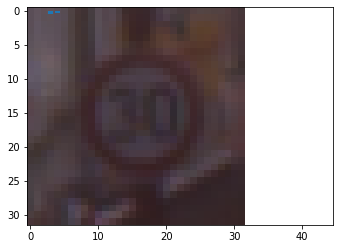

In [0]:

plt.bar(range(43), y_pred_prob[422])
# Image, label, pred
plt.imshow(X_test[422]), labels_dict[np.argmax(y_test[422])], labels_dict[np.argmax(y_pred_prob[422])]

==============================================================================

In [0]:
!git pull